### **Sepehr Rezaee - 99242067**

## **Import Requirements**

In [ ]:
import os
import torch
import random
import argparse
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


%matplotlib inline


## **Download and Load the dataset**

In [ ]:
# Download and load the CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def get_my_dataset(size=100, flag=True):
    indexes = random.sample(range(0, 5000), size)
    divsure = 4
    group1 = indexes[:size//divsure]
    group2 = indexes[size//divsure:]
    dataset = torchvision.datasets.CIFAR10(root='./data', train=flag,
                                    download=True, transform=transform)
    pair_indexes = [(i, j) for i in group1 for j in group2]

    def get_item(idx):
        index1, index2 = pair_indexes[idx]
        img1 = dataset[index1][0]
        img2 = dataset[index2][0]
        result = img1 + img2
        result = result / 2
        return result, (img1, img2)

    return len(pair_indexes), get_item


# Create a custom dataset object that wraps the get_item function
class MyDatasetObject:
    def __init__(self, length, get_item):
        self.length = length
        self.get_item = get_item

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.get_item(idx)

## **Define the encoder and decoder and autoencoder networks**

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

# Encoder
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

# Decoder
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()


        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)


        self.b = conv_block(512, 1024)


        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        self.d11 = decoder_block(1024, 512)
        self.d22 = decoder_block(512, 256)
        self.d33 = decoder_block(256, 128)
        self.d44 = decoder_block(128, 64)


        self.outputs = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, inputs):

        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)


        b = self.b(p4)


        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        d11 = self.d11(b, s4)
        d22 = self.d22(d11, s3)
        d33 = self.d33(d22, s2)
        d44 = self.d44(d33, s1)


        outputs1 = self.outputs(d4)
        outputs2 = self.outputs(d44)

        return outputs1, outputs2

In [ ]:
# Create the U-Net model
model = build_unet()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
length, get_item = get_my_dataset()

dataset = MyDatasetObject(length, get_item)

# Create a DataLoader from the dataset
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)


Files already downloaded and verified


## **Train the autoencoder**

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for i, (inputs, (img1, img2)) in enumerate(data_loader, 0):
        outputs1, outputs2 = model(inputs)
        loss1 = criterion(outputs1, img1)
        loss2 = criterion(outputs2, img2)
        loss = (loss1 + loss2) / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('.',end='',flush=True)

    print('\r',end='')
    print(f'Epoch : {epoch+1}/{num_epochs}, Loss : {loss.data}')

Epoch : 1/10, Loss : 0.13804861903190613
Epoch : 2/10, Loss : 0.10240800678730011
Epoch : 3/10, Loss : 0.06953547894954681
Epoch : 4/10, Loss : 0.05312111973762512
Epoch : 5/10, Loss : 0.04707729071378708
Epoch : 6/10, Loss : 0.035461291670799255
Epoch : 7/10, Loss : 0.02903291955590248
Epoch : 8/10, Loss : 0.025823332369327545
Epoch : 9/10, Loss : 0.01703120768070221
Epoch : 10/10, Loss : 0.01638597995042801


## **Test the U-Net model**

In [ ]:
length, get_item = get_my_dataset()

dataset = MyDatasetObject(length, get_item)

# Create a DataLoader from the dataset
test_data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)


Files already downloaded and verified


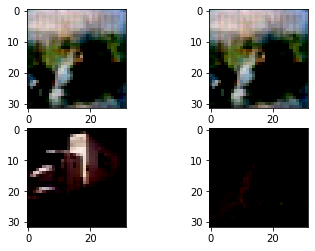

In [ ]:
for i, (input_batch, (output_batch1, output_batch2)) in enumerate(test_data_loader, 0):
    # Compute the mean image
    mean_image = (output_batch1 + output_batch2) / 2

    # Display the mean image
    print("mean image: ")
    mean_image_np = mean_image[0].cpu().detach().numpy()
    plt.imshow(np.transpose(mean_image_np, (1, 2, 0)))
    plt.show()

    # Display image 1
    print("image 1: ")
    image1_np = output_batch1[0].cpu().detach().numpy()
    plt.imshow(np.transpose(image1_np, (1, 2, 0)))
    plt.show()

    # Display image 2
    print("image 2: ")
    image2_np = output_batch2[0].cpu().detach().numpy()
    plt.imshow(np.transpose(image2_np, (1, 2, 0)))
    plt.show()



    # Predict image 1 and image 2
    predict1 = model(input_batch)[0][1]
    predict2 = model(input_batch)[0][1]

    # Display the predicted images
    print("predicted image 1: ")
    predict1_np = predict1.cpu().detach().numpy()
    plt.imshow(np.transpose(predict1_np, (1, 2, 0)))
    plt.show()

    print("predicted image 2: ")
    predict2_np = predict2.cpu().detach().numpy()
    plt.imshow(np.transpose(predict2_np, (1, 2, 0)))
    plt.show()

    # fig, axs = plt.subplots(2, 2)
    # axs[1, 0].imshow(np.transpose(image1_np, (1, 2, 0)))
    # axs[1, 1].imshow(np.transpose(image2_np, (1, 2, 0)))
    # axs[0, 0].imshow(np.transpose(predict1_np, (1, 2, 0)))
    # axs[0, 1].imshow(np.transpose(predict2_np, (1, 2, 0)))

    break



## **Save the model parametrs**

In [ ]:
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(model.state_dict(), "./weights/autoencoder.pkl")